In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP
from layers import GraphConv
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.sparse.csgraph import connected_components

from tqdm import trange
import numpy as np
import copy 
import time
import pickle
import os

DATASET = 'citeseer'
SAVE_DIR = './exp_results/figures/%s/'%DATASET

layers = [i for i in range(2,11)]
repeats = [i for i in range(10)]   

In [2]:
def get_sigW_mean(sigW):
    results = []
    for k, v in sigW.items():
        results.append(v)
    return np.mean(results)

def get_result(ALGORITHM, layer, repeat):
    save_path = os.path.join('exp_results/%s/'%DATASET, 
                             'results_%s_L%d_repteat%d.pkl'%(DATASET, layer, repeat))
    with open(save_path, 'rb') as f:
        results_list = pickle.load(f)

    result = None
    for result_ in results_list:
        if result_.note == '%s (L=%d)'%(ALGORITHM, layer):
            result = result_
            break
            
    return result.dM_before, result.dM_after, result.test_acc, \
            get_sigW_mean(result.w_sigval_before), get_sigW_mean(result.w_sigval_after)

In [3]:
dM_before = []
dM_after = []
test_acc = []
w_sigval_before = []
w_sigval_after = []

In [4]:
SAVE_DIR = '/home/weilin/Downloads/cora_result/'

In [5]:
for ALGORITHM in ['GCN', 'GCNBias', 'SGC', 'ResGCN', 'GCNII', 'APPNP']:
    dM_before_list = [[1,0]]
    dM_after_list = [[1,0]]
    test_acc_list = []
    w_sigval_before_list = []
    w_sigval_after_list = []

    for layer in range(2, 11):
        dM_before = []
        dM_after = []
        test_acc = []
        w_sigval_before = []
        w_sigval_after = []
        for repeat in range(10):
            dM_before_, dM_after_, test_acc_, w_sigval_before_, w_sigval_after_ = get_result(ALGORITHM, layer, repeat)
            dM_before.append(dM_before_[-1] / dM_before_[0])
            dM_after.append(dM_after_[-1] / dM_after_[0])
            test_acc.append(test_acc_)
            w_sigval_before.append(w_sigval_before_)
            w_sigval_after.append(w_sigval_after_)
        dM_before_list.append([np.mean(dM_before, axis=0), np.std(dM_before, axis=0)])
        dM_after_list.append([np.mean(dM_after, axis=0), np.std(dM_after, axis=0)])
        test_acc_list.append([np.mean(test_acc), np.std(test_acc)])
        w_sigval_before_list.append([np.mean(w_sigval_before), np.std(w_sigval_before)])
        w_sigval_after_list.append([np.mean(w_sigval_after), np.std(w_sigval_after)])

    # plot dM_before
    fig, axs = plt.subplots()

    y_vals = np.array(dM_before_list)[:, 0]
    y_stds = np.array(dM_before_list)[:, 1]
    x_vals = np.array([0] + [i+2 for i in range(len(y_vals)-1)])

    w_sig_mean, w_sig_stds = np.mean(w_sigval_before_list, axis=0)
    axs.plot(x_vals, y_vals, label='Before training ($\lambda_{\max}$(W) = %.3f $\pm$ %.3f)'%(w_sig_mean, w_sig_stds))
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    plt.title('%s: $d_M(H^{(\ell)}) / d_M(H^{(0)})$ / Num of layers'%ALGORITHM)
    axs.set_xlabel('Num of layers')
    axs.set_ylabel('$d_M(H^{(\ell)}) / d_M(H^{(0)})$')
    axs.grid(True)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    fig.tight_layout()
    plt.legend()
    plt.savefig(SAVE_DIR+'dM_before_%s.pdf'%(ALGORITHM))
    plt.close()
    # plot dM_after
    fig, axs = plt.subplots()

    y_vals = np.array(dM_after_list)[:, 0]
    y_stds = np.array(dM_after_list)[:, 1]
    x_vals = np.array([0] + [i+2 for i in range(len(y_vals)-1)])

    w_sig_mean, w_sig_stds = np.mean(w_sigval_after_list, axis=0)
    axs.plot(x_vals, y_vals, label='After training ($\lambda_{\max}$(W) = %.3f $\pm$ %.3f)'%(w_sig_mean, w_sig_stds))
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    plt.title('%s: $d_M(H^{(\ell)}) / d_M(H^{(0)})$ / Num of layers'%ALGORITHM)
    axs.set_xlabel('Num of layers')
    axs.set_ylabel('$d_M(H^{(\ell)}) / d_M(H^{(0)})$')
    axs.grid(True)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    fig.tight_layout()
    plt.legend()
    plt.savefig(SAVE_DIR+'dM_after_%s.pdf'%(ALGORITHM))
    plt.close()

    # plot Test F1-score
    fig, axs = plt.subplots()

    y_vals = np.array(test_acc_list)[:, 0]
    y_stds = np.array(test_acc_list)[:, 1]
    x_vals = np.array([i+2 for i in range(len(y_vals))])

    w_sig_mean, w_sig_stds = np.mean(w_sigval_before_list, axis=0)
    axs.plot(x_vals, y_vals, label='Testing F1-score')
    axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

    plt.title('%s: Testing F1-score / Num of layers'%ALGORITHM)
    axs.set_xlabel('Num of layers')
    axs.set_ylabel('F1-score')
    axs.grid(True)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    fig.tight_layout()
    plt.legend()
    plt.savefig(SAVE_DIR+'test_f1_%s.pdf'%(ALGORITHM))
    plt.close()

/home/weilin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/weilin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/weilin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/weilin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
a,b = np.mean(w_sigval_before_list, axis=0)
a

nan

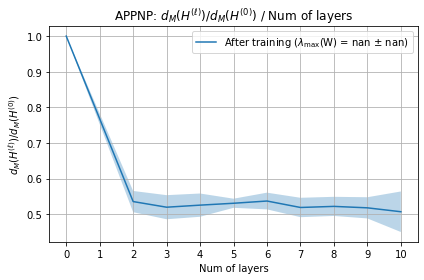

In [7]:
fig, axs = plt.subplots()

# plot dM_before
y_vals = np.array(dM_after_list)[:, 0]
y_stds = np.array(dM_after_list)[:, 1]
x_vals = np.array([0] + [i+2 for i in range(len(y_vals)-1)])

w_sig_mean, w_sig_stds = np.mean(w_sigval_after_list, axis=0)
axs.plot(x_vals, y_vals, label='After training ($\lambda_{\max}$(W) = %.3f $\pm$ %.3f)'%(w_sig_mean, w_sig_stds))
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('%s: $d_M(H^{(\ell)}) / d_M(H^{(0)})$ / Num of layers'%ALGORITHM)
axs.set_xlabel('Num of layers')
axs.set_ylabel('$d_M(H^{(\ell)}) / d_M(H^{(0)})$')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

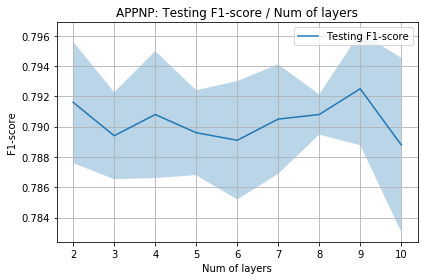

In [8]:
fig, axs = plt.subplots()

# plot dM_before
y_vals = np.array(test_acc_list)[:, 0]
y_stds = np.array(test_acc_list)[:, 1]
x_vals = np.array([i+2 for i in range(len(y_vals))])

w_sig_mean, w_sig_stds = np.mean(w_sigval_before_list, axis=0)
axs.plot(x_vals, y_vals, label='Testing F1-score')
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('%s: Testing F1-score / Num of layers'%ALGORITHM)
axs.set_xlabel('Num of layers')
axs.set_ylabel('F1-score')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

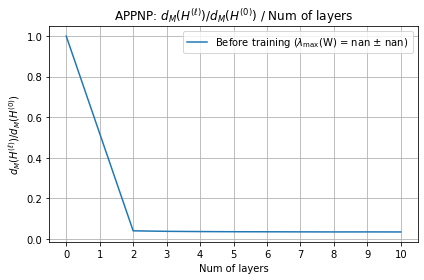

In [9]:
fig, axs = plt.subplots()

# plot dM_before
y_vals = np.array(dM_before_list)[:, 0]
y_stds = np.array(dM_before_list)[:, 1]
x_vals = np.array([0] + [i+2 for i in range(len(y_vals)-1)])

w_sig_mean, w_sig_stds = np.mean(w_sigval_before_list, axis=0)
axs.plot(x_vals, y_vals, label='Before training ($\lambda_{\max}$(W) = %.3f $\pm$ %.3f)'%(w_sig_mean, w_sig_stds))
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('%s: $d_M(H^{(\ell)}) / d_M(H^{(0)})$ / Num of layers'%ALGORITHM)
axs.set_xlabel('Num of layers')
axs.set_ylabel('$d_M(H^{(\ell)}) / d_M(H^{(0)})$')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

In [10]:
def get_sigW_mean(sigW):
    results = []
    for k, v in sigW.items():
        results.append(v)
    return np.mean(results)